# LightGBM: Train without COVID-19 period

### Setup

In [1]:
import sys
sys.path.append('../')
from src.load_data import *
from src.realtime_utils import *
from src.hp_tuning_functions import *

In [2]:
from darts.models.forecasting.lgbm import LightGBMModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dwolffram (dwolffram-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


True

### Configuration

In [4]:
NUM_SAMPLES = 1000
HORIZON = 4

ENCODERS = {
    'datetime_attribute': {'future': ['month', 'weekofyear']}
}

# Load best model

In [5]:
params = get_best_parameters('sari-lightgbm', 'lightgbm', 'WIS', sample_weight='linear')

WIS of best run: 447.06267950493736


In [6]:
params = get_best_parameters('sari-lightgbm', 'lightgbm', 'WIS', sample_weight='no-covid')

WIS of best run: 448.5029175270846


In [7]:
{key: params[key] for key in sorted(params)}

{'colsample_bytree': 0.8,
 'lags': 8,
 'lags_future_covariates': [0, 1],
 'lags_past_covariates': {'agi-are-05-14': 8,
  'agi-are-DE': 8,
  'agi-are-15-34': 8,
  'agi-are-35-59': 8,
  'default_lags': 1,
  'agi-are-00-04': 8,
  'agi-are-60+': 8},
 'learning_rate': 0.1,
 'max_bin': 1024,
 'max_depth': -1,
 'min_child_samples': 10,
 'min_split_gain': 0,
 'model': 'lightgbm',
 'multiple_series': False,
 'n_estimators': 500,
 'num_leaves': 20,
 'reg_alpha': 0.5,
 'reg_lambda': 0.5,
 'sample_weight': 'no-covid',
 'subsample': 0.8,
 'subsample_freq': 1,
 'use_covariates': True,
 'use_encoders': True,
 'use_features': False,
 'use_static_covariates': False}

In [8]:
name = params.pop('model')
multiple_series = params.pop('multiple_series')
use_covariates = params.pop('use_covariates')
use_features = params.pop('use_features')
use_encoders = params.pop('use_encoders')
sample_weight = params.pop('sample_weight')

if not use_covariates:
    del params['lags_past_covariates']
    
model = LightGBMModel(
    **params,
    output_chunk_length=HORIZON,
    add_encoders=ENCODERS if use_encoders else None,
    likelihood="quantile",
    quantiles=QUANTILES,
    verbose=-1,
)

# Load data

In [10]:
targets, covariates = load_realtime_training_data()

In [12]:
custom_weights = exclude_covid_weights(targets)

<Axes: xlabel='date'>

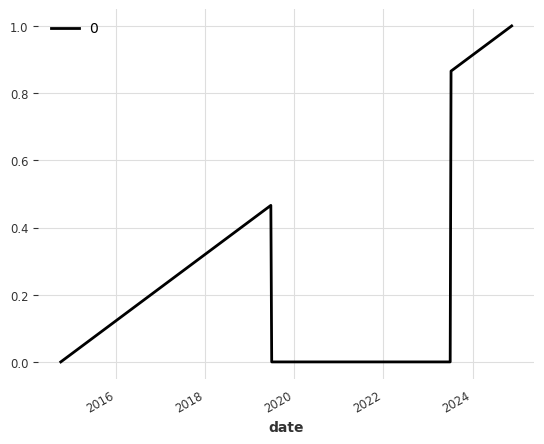

In [18]:
custom_weights.plot()

In [19]:
forecast_dates = sorted([filename.split('/')[-1][:10] for filename in glob.glob('../data/nowcasts/KIT-baseline/*.csv')])

In [20]:
forecast_dates = [f for f in forecast_dates if f >= '2023-11-16' and f <= '2024-09-12']

# Train model

In [21]:
RANDOM_SEEDS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
for forecast_date in forecast_dates:
    
    path = f'../models/post-covid/{forecast_date}/'
    os.makedirs(path, exist_ok=True)

    targets, covariates = load_realtime_training_data(as_of=forecast_date)

    for seed in RANDOM_SEEDS:
        model_path = path + f'{forecast_date}-lightgbm_noCovid-{seed}.pt'
        print(model_path)
        model = LightGBMModel(
            **params,
            output_chunk_length=HORIZON,
            add_encoders=ENCODERS if use_encoders else None,
            likelihood="quantile",
            quantiles=QUANTILES,
            verbose=-1,
            random_state=seed
        )
        model.fit(targets, past_covariates=covariates if use_covariates else None, sample_weight=custom_weights if sample_weight == "no-covid" else sample_weight)
        model.save(model_path)

# Forecast

In [23]:
RANDOM_SEEDS = [1, 2, 3, 4, 5 , 6, 7, 8, 9, 10]

In [24]:
NAME = 'lightgbm_noCovid'

In [25]:
#forecast_dates = sorted([filename.split('/')[-1][:10] for filename in glob.glob('../data/nowcasts/KIT-baseline/*.csv')])

In [26]:
targets, covariates = load_realtime_training_data()

In [27]:
def compute_ensemble(forecast_date, export=False):
    dfs = []
    for seed in RANDOM_SEEDS:
        print(seed)
        model_path = f'../models/post-covid/{forecast_date}/{forecast_date}-lightgbm_noCovid-{seed}.pt'
        model = LightGBMModel.load(model_path)
        df = compute_forecast(model, targets, covariates, forecast_date, HORIZON, NUM_SAMPLES, vincentization=False, probabilistic_nowcast=True, local=True)
        dfs.append(df)

    df = pd.concat(dfs)
    df = df.groupby(['location', 'age_group', 'forecast_date', 'target_end_date', 'horizon', 'type', 'quantile']).agg({'value': 'mean'}).reset_index()

    df = df.sort_values(['location', 'age_group', 'horizon', 'quantile'])
    
    if export:
        df.to_csv(f'../data/post-covid/submissions/{NAME}/{forecast_date}-icosari-sari-{NAME}.csv', index=False)
        return df
    else:
        return df

In [28]:
forecasts = []
for forecast_date in forecast_dates:
    print(forecast_date)
    forecast = compute_ensemble(forecast_date, export=True)
    forecasts.append(forecast)

2023-11-16
1
2
3
4
5
6
7
8
9
10
2023-11-23
1
2
3
4
5
6
7
8
9
10
2023-11-30
1
2
3
4
5
6
7
8
9
10
2023-12-07
1
2
3
4
5
6
7
8
9
10
2023-12-14
1
2
3
4
5
6
7
8
9
10
2023-12-21
1
2
3
4
5
6
7
8
9
10
2023-12-28
1
2
3
4
5
6
7
8
9
10
2024-01-04
1
2
3
4
5
6
7
8
9
10
2024-01-11
1
2
3
4
5
6
7
8
9
10
2024-01-18
1
2
3
4
5
6
7
8
9
10
2024-01-25
1
2
3
4
5
6
7
8
9
10
2024-02-01
1
2
3
4
5
6
7
8
9
10
2024-02-08
1
2
3
4
5
6
7
8
9
10
2024-02-15
1
2
3
4
5
6
7
8
9
10
2024-02-22
1
2
3
4
5
6
7
8
9
10
2024-02-29
1
2
3
4
5
6
7
8
9
10
2024-03-07
1
2
3
4
5
6
7
8
9
10
2024-03-14
1
2
3
4
5
6
7
8
9
10
2024-03-21
1
2
3
4
5
6
7
8
9
10
2024-03-28
1
2
3
4
5
6
7
8
9
10
2024-04-04
1
2
3
4
5
6
7
8
9
10
2024-04-11
1
2
3
4
5
6
7
8
9
10
2024-04-18
1
2
3
4
5
6
7
8
9
10
2024-04-25
1
2
3
4
5
6
7
8
9
10
2024-05-02
1
2
3
4
5
6
7
8
9
10
2024-05-09
1
2
3
4
5
6
7
8
9
10
2024-05-16
1
2
3
4
5
6
7
8
9
10
2024-05-23
1
2
3
4
5
6
7
8
9
10
2024-05-30
1
2
3
4
5
6
7
8
9
10
2024-06-06
1
2
3
4
5
6
7
8
9
10
2024-06-13
1
2
3
4
5
6
7
8
9
10
2024-06-

# Oracle nowcast

In [26]:
RANDOM_SEEDS = [1, 2, 3, 4, 5 , 6, 7, 8, 9, 10]

In [31]:
NAME = 'lightgbm_oracle'

In [28]:
#forecast_dates = sorted([filename.split('/')[-1][:10] for filename in glob.glob('../data/nowcasts/KIT-baseline/*.csv')])

In [29]:
targets, covariates = load_realtime_training_data()

In [30]:
def compute_forecast(model, target_series, covariates, forecast_date, horizon, num_samples, vincentization=True, probabilistic_nowcast=True, local=False, oracle_nowcast=True):
    '''
    For every sample path given by the nowcasted quantiles, a probabilistic forecast is computed.
    These are then aggregated into one forecast by combining all predicted paths.
    '''
    
    if oracle_nowcast:
        target_list = target_series[:pd.Timestamp(forecast_date)]
        
    else:
        indicator = target_series.components[0].split('-')[1]
        ts_nowcast = load_nowcast(forecast_date, probabilistic_nowcast, indicator, local)
        target_list = make_target_paths(target_series, ts_nowcast)
        target_list = [encode_static_covariates(t, ordinal=False) for t in target_list]

        covariates = [covariates]*len(target_list) if covariates else None
      
    fct = model.predict(n=horizon, 
                        series=target_list, 
                        past_covariates=covariates, 
                        num_samples=num_samples)
    
    df = reshape_forecast(fct)
        
    return df

In [32]:
def compute_ensemble(forecast_date, export=False):
    dfs = []
    for seed in RANDOM_SEEDS:
        print(seed)
        model_path = f'../models/post-covid/{forecast_date}/{forecast_date}-lightgbm-{seed}.pt'
        model = LightGBMModel.load(model_path)
        df = compute_forecast(model, targets, covariates, forecast_date, HORIZON, NUM_SAMPLES, vincentization=False, probabilistic_nowcast=True, local=True, oracle_nowcast=True)
        dfs.append(df)

    df = pd.concat(dfs)
    df = df.groupby(['location', 'age_group', 'forecast_date', 'target_end_date', 'horizon', 'type', 'quantile']).agg({'value': 'mean'}).reset_index()

    df = df.sort_values(['location', 'age_group', 'horizon', 'quantile'])
    
    if export:
        df.to_csv(f'../data/post-covid/submissions/{NAME}/{forecast_date}-icosari-sari-{NAME}.csv', index=False)
        return df
    else:
        return df

In [33]:
targets[:pd.Timestamp('2023-11-16')].end_time()

Timestamp('2023-11-12 00:00:00')

In [94]:
df = compute_ensemble(forecast_dates[5])

1
2
3
4
5
6
7
8
9
10


In [ ]:
forecasts = []
for forecast_date in forecast_dates:
    print(forecast_date)
    forecast = compute_ensemble(forecast_date, export=True)
    forecasts.append(forecast)